# 3.5 Gene expression analysis using DESeq2

#### First use `git` to retrieve the gene counts files (total n=6). The path to files on the Github repo is:
`Applied-Bioinformatics/Unit2-RNAseq/data/htseq_out/day5/`  
  
Then copy to a directory where you can find it (e.g. your homework folder).
#### Locate counts files 
```R
dir_counts <- "/mnt/c/Users/Jerry/Applied-Bioinformatics-HW/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
counts_files
```

In [2]:
dir_counts <- "/mnt/c/Users/Jerry/Applied-Bioinformatics-HW/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
counts_files

[1] "GSM2580321_counts.txt" "GSM2580322_counts.txt" "GSM2580325_counts.txt"
[4] "GSM2580326_counts.txt" "GSM2580329_counts.txt" "GSM2580330_counts.txt"

#### Prepare a sample table in the format required by DESeq2
Here we specify the group assignment manually. It is also possible to parse the sample data matrix from GEO, which can be found by following a link on the data series page: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE97919
```
samplesInfo <- as.data.frame(matrix(ncol=2, nrow=length(counts_files)))  
samplesInfo$samplename <- counts_files  
samplesInfo$filename <- counts_files  
samplesInfo$group <- c("mock", "ZIKV", "mock", "ZIKV", "mock", "ZIKV") 
#Remove the blank columns
samplesInfo <- samplesInfo[,-c(1:2)]
```

#### Check the sample table and make any corrections above if necessary

In [4]:
samplesInfo
class(samplesInfo)

samplename,filename,group
GSM2580321_counts.txt,GSM2580321_counts.txt,mock
GSM2580322_counts.txt,GSM2580322_counts.txt,ZIKV
GSM2580325_counts.txt,GSM2580325_counts.txt,mock
GSM2580326_counts.txt,GSM2580326_counts.txt,ZIKV
GSM2580329_counts.txt,GSM2580329_counts.txt,mock
GSM2580330_counts.txt,GSM2580330_counts.txt,ZIKV


[1] "data.frame"

#### Load DESeq2 package
```
library("DESeq2")
```

#### Import data into R
```
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)
```

In [6]:
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”

#### Check the data imported correctly
```R
colData(dds1)
```

In [7]:
colData(dds1)

DataFrame with 6 rows and 1 column
                         group
                      <factor>
GSM2580321_counts.txt     mock
GSM2580322_counts.txt     ZIKV
GSM2580325_counts.txt     mock
GSM2580326_counts.txt     ZIKV
GSM2580329_counts.txt     mock
GSM2580330_counts.txt     ZIKV

In [8]:
#### Run the main DESeq normalization and analysis function
dds1_deseq <- DESeq(dds1)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


#### Run additional DESeq2 normalization functions
```
rld <- rlog(dds1_deseq)
vsd <- varianceStabilizingTransformation(dds1_deseq)
```

#### Plot a dendrogram of sample transcriptomes
```
sampleDists <- dist(t(assay(vsd)))
plot(hclust(sampleDists))
```

#### Principal component plot
```
plotPCA(rld, intgroup="group")
```

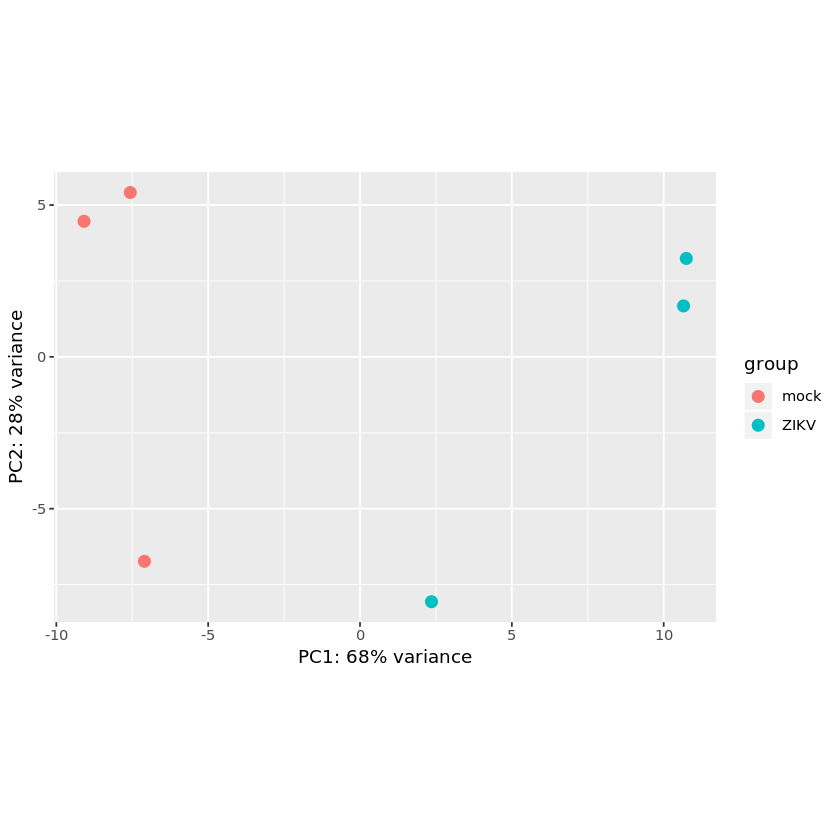

In [11]:
plotPCA(rld, intgroup="group")

#### PCA plot with variance-stabilized counts

```R
plotPCA(vsd, intgroup="group")
```

#### Exercises (class 3.5)
1) Repeat the hierarchical clustering using rlog-normalized counts instead of vsd.  
2) Examine the normalized counts using `head(assay(vsd))` and `head(assay(rld))`. Now find the corresponding raw counts and plot raw vs normalized counts for the first 6 genes of the first sample. HINT: It is possible to extract elements from `dds1`, including raw counts. 

## 3.6 Differential expression analysis
Differential expression analysis compares two groups of samples to each other. In its simplest version, the analysis design uses a single factor to divide samples into groups and compares those to each other (single-factor design).

### Single factor design differential analysis
#### First check the sample table we are selecting from

```
colData(dds1_deseq)
```

#### Specify sample groups that should be compared
The general format of this command is:
```
results(dds_deseq, contrast = c("factorName", "factorLevel1", "factorLevel2")
```
Note that `factorLevel2` will be used as the reference level (i.e. positive fold change means gene upregulated in factorLevel1)

In [18]:
res <- results(dds1_deseq, contrast=c("group", "ZIKV", "mock"))
summary(res)


out of 37609 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 461, 1.2%
LFC < 0 (down)     : 476, 1.3%
outliers [1]       : 9, 0.024%
low counts [2]     : 20516, 55%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



#### Examine differential expression summary
The summary above contains important information about the calculation.     
  
1) Applying a threshold of adjusted p<0.1, we see the number of genes that are differentially expressed.  
2) Many genes fall into 'low counts', i.e. were filtered out due to low counts. This is caused by the independentFiltering function which can be swiched off (argument `independentFilering=FALSE`). One can also see the read count below which the genes were filtered out.  

#### Examine differentially expressed genes
First let us sort the gene by p value, then examine the top differentially expressed genes.

```R
resSorted <- res[order(res$padj),]
head(resSorted)
```

#### Convert gene symbols
Interpreting Ensembl IDs is impractical. We can convert them to gene symbols, for example using the biomaRt package. You should have the package installed already (see RNAseq configuration). This package also functions as an API to retrieve various gene annotations so we can fetch them on the fly.

```R
library("biomaRt")
bm <- useMart(biomart = "ensembl")
bm <- useDataset(dataset = "hsapiens_gene_ensembl", mart = bm)
ens2genesymbol <- getBM(mart = bm, attributes = c('ensembl_gene_id', 'external_gene_name'))
```

We can look up individual Ensembl IDs using the `%in%` operator

```
which(ens2genesymbol$ensembl_gene_id %in% rownames(resSorted)[1])
```

We see the row number of the top gene by pvalue is 8416 in the `ens2genesymbol` lookup table.

In [61]:
ens2genesymbol[8416,]

,ensembl_gene_id,external_gene_name
8416,ENSG00000213928,IRF9


#### But it is better to create a list of the positions of the genes of interest in the ens2genesymbol data frame

```R
ngenes <- 25
genelist <- list()
for (i in 1:ngenes){
    genelist[[i]] <- which(ens2genesymbol$ensembl_gene_id %in% rownames(resSorted)[i])
    names(genelist)[i] <- ens2genesymbol[genelist[[i]], "external_gene_name"]
    }
head(genelist)
```

#### Plot normalized counts
DESeq2 provides a function to plot counts for a selected gene with samples spit up into groups of interest. These counts are normalized for library size but not by variance stabilizing or rlog transformation.

```R
plotCounts(dds1_deseq, gene = rownames(resSorted)[1], 
           intgroup = "group", 
           main = ens2genesymbol[8416,2])
```

**Exercise 1**   
Look up the top 10 differentially expressed genes by p value and print their gene names. Does this gene list suggest what biological pathway could be involved?  
**Exercise 2**   
Export the table of differentially expressed genes in a comma- or tab-delimited format.

## Visual summary of differential expression data
Commonly used visualizations of DE data include the volcano plot (fold change vs -logP) and the heatmap. 

### Basic volcano plot
NB: the default of the `log` function is a natural log (base = e). A base 10 log has to be specified explicitly using the argument `base = 10`.

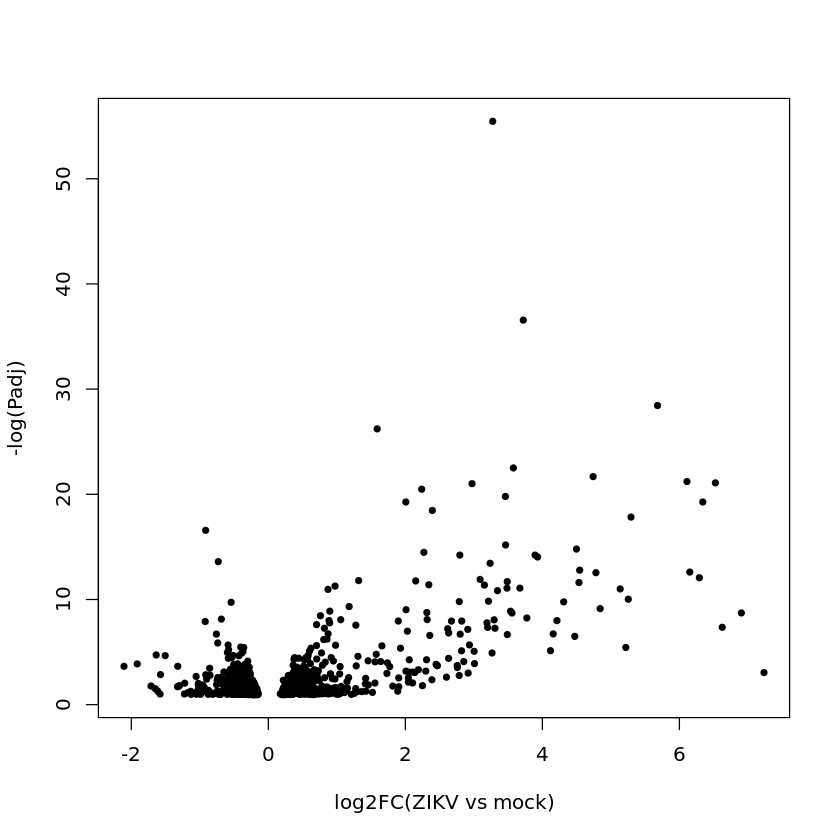

In [95]:
ngenes <- 1000
volcanodf <- as.data.frame(matrix(nrow=ngenes, ncol=2))
volcanodf$y <- -log(resSorted[1:ngenes, "padj"], base = 10)
volcanodf$x <- resSorted[1:ngenes, "log2FoldChange"]
volcanodf$gene <- rownames(resSorted)[1:ngenes]
volcanodf <- volcanodf[,-c(1:2)]

plot(volcanodf$x, volcanodf$y,
    ylab = "-log(Padj)", 
    xlab = "log2FC(ZIKV vs mock)",
    pch = 20)

#### Volcano plot centered at fold change = 1

```
fcmax <- max(na.omit(resSorted$log2FoldChange))

plot(volcanodf$x, volcanodf$y,
    ylab = "-log(Padj)", 
    xlab = "log2FC(ZIKV vs mock)",
    pch = 20,
    xlim = c(-(fcmax - 0.5), (fcmax + 0.5)))
```

#### Volcano plot with gene labels

```
fcmax <- max(na.omit(resSorted$log2FoldChange))

plot(volcanodf$x, volcanodf$y,
    ylab = "-log(Padj)", 
    xlab = "log2FC(ZIKV vs mock)",
    pch = 20,
    xlim = c(-(fcmax - 0.5), (fcmax + 0.5)))

text(volcanodf[1:10, "x"], volcanodf[1:10, "y"], labels=volcanodf[1:10, "gene"])
```

### Heatmaps of DEGs
A heatmap shows each gene's *relative* expression. In case of differential expression analysis, it is often best to choose the mean level across all samples as a reference.

#### The minimal heatmap

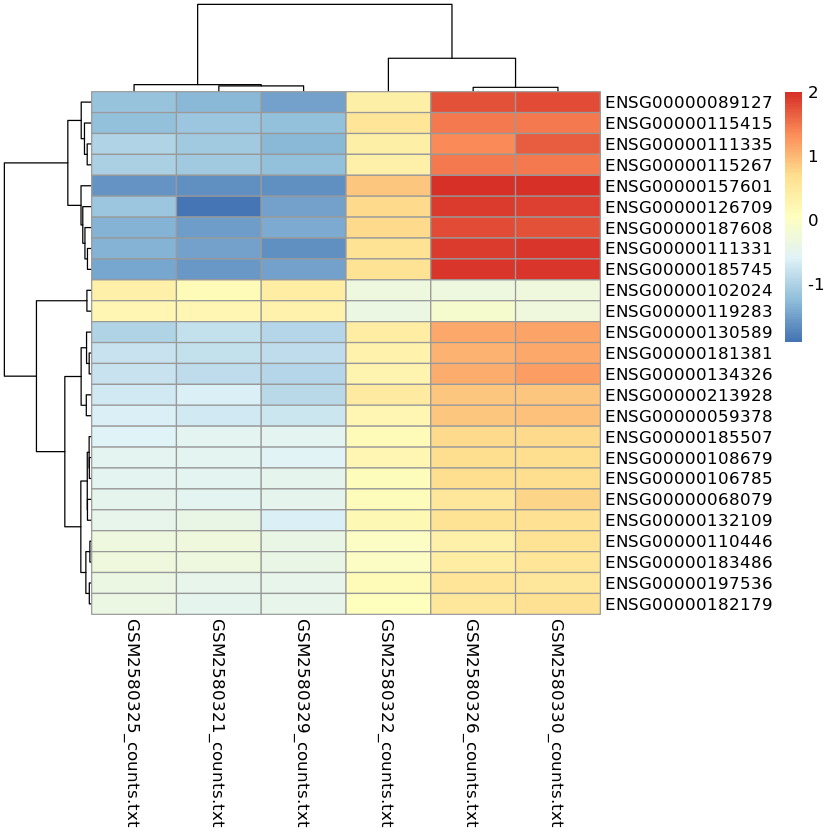

In [100]:
library("pheatmap")
ngenes <- 25
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
pheatmap(mat)

#### Plot heatmap with sample group data and gene names

```R
df <- as.data.frame(colData(rld))

ngenes <- 25
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
rownames(mat) <- names(genelist)

pheatmap(mat,
        annotation_col = df,
        cluster_cols = T)
```

### Exercises  
**Exercise 3** Make a volcano plot on which all genes with an adjusted P < 10^-10 are coloured red, and add a vertical line highlighting a fold change cut-off of 2 (linear fold change = 2 or 1/2).  
**Exercise 4** Change the volcano plot gene labels to gene symbols instead of Ensembl IDs (for top 5 or 10 genes by pvalue).  
**Exercise 5** Make a heatmap of the top 25 genes that are *downregulated* in the mock infected vs ZIKV-infected group, (top 25 meaning by p value).